## Практический кейс 1. Анализ банковских данных 

Признаки клиентов банка:

- ```age``` - возраст (вещественный)
- ```MonthlyIncome``` - месячный доход (вещественный)
- ```DebtRatio``` - Debt-to-income Ratio (вещественный)
- ```NumberOfOpenCreditLinesAndLoans``` - число заемов и кредитных линий
- ```NumberRealEstateLoansOrLines``` - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- ```NumberOfDependents``` - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- ```defaulted``` - выплачен или не выплачен в конечном итоге кредит заемщиком

В этой работе я буду исследовать данные о заемщиках и отвечу на вопросы о предоставленных данных.

In [3]:
import pandas as pd

## Базовые операции с датафреймом

Считаем файл ```credit_data.csv``` в переменную ```df```

In [6]:
df = pd.read_csv('data/credit_data.csv')

Определим размер таблицы

In [9]:
df.shape

(150000, 8)

Посмотрим первые пять строк

In [10]:
df.head()

,defaulted,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,age_group
0,1,45,0.802982,9120.0,13,6,2.0,2
1,0,40,0.121876,2600.0,4,0,1.0,2
2,0,38,0.085113,3042.0,2,0,0.0,2
3,0,30,0.036050,3300.0,5,0,0.0,1
4,0,49,0.024926,63588.0,7,1,0.0,2


Выведем список названий столбцов

In [11]:
df.columns

Index(['defaulted', 'age', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents', 'age_group'],
      dtype='object')

Определим число пропусков в каждом столбце

In [12]:
df.isnull().sum()

defaulted                              0
age                                    0
DebtRatio                              0
MonthlyIncome                      29731
NumberOfOpenCreditLinesAndLoans        0
NumberRealEstateLoansOrLines           0
NumberOfDependents                  3924
age_group                              0
dtype: int64

Определим долю пропусков в каждом столбце

In [13]:
df.isnull().mean()

defaulted                          0.000000
age                                0.000000
DebtRatio                          0.000000
MonthlyIncome                      0.198207
NumberOfOpenCreditLinesAndLoans    0.000000
NumberRealEstateLoansOrLines       0.000000
NumberOfDependents                 0.026160
age_group                          0.000000
dtype: float64

Определим общее количество пропущенных значений в таблице

In [14]:
df.isnull().sum().sum()

33655

Определим количество заемщиков, у которых ежемесячный доход ```MonthlyIncome``` выше среднего.

In [15]:
average_monthly_income = df['MonthlyIncome'].mean()
df[df['MonthlyIncome'] > average_monthly_income]['MonthlyIncome'].count()

44146

Вычислим медианный возраст заемщиков, которые не вернули кредит.

In [16]:
df[df['defaulted'] == 1]['age'].median()

45.0

In [17]:
df[df['defaulted'] == 0]['age'].median()

52.0

Определите долю заемщиков, которые не выплатили кредит

In [18]:
df['defaulted'].mean()

0.06684

## Вычисление новых признаков и группировка данных

Вычислим новый признак ```age_group``` на основе признака ```age```, который разбивает заемщиков на 3 возрастные группы:
- до 30 лет включительно - группа 1
- от 30 лет не включительно и до 50 лет включительно - группа 2
- строго старше 50 лет - группа 3

In [19]:
def calculate_age_group(age):
    if age <= 30:
        return 1
    if 30 < age <= 50:
        return 2
    return 3

In [20]:
# вычисление нового признака на основе age с разделением на 3 возрастные группы
my_age_group = df['age'].apply(lambda age: calculate_age_group(age))

In [21]:
# проверка корректности нового признака
(my_age_group == df['age_group']).all()

True

Посчитаем долю заемщиков, которые не вернули кредит, в каждой из вычисленных возрастных групп.

In [22]:
df_age_group = df.groupby('age_group')['defaulted'].mean()
df_age_group

age_group
1    0.115635
2    0.088975
3    0.043811
Name: defaulted, dtype: float64

Визуализируем полученные данные в виде гистограммы.

Импортируем модуль для визуализации данных.

In [23]:
from matplotlib import pyplot as plt

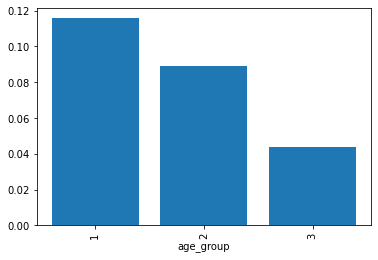

In [24]:
x = df_age_group.index
y = df_age_group.values
plt.bar(x, y)
plt.xticks([1, 2, 3], rotation=90)
plt.xlabel('age_group')
plt.show()

**Вывод на основании проведённого анализа.**

Можно заметить, что увеличением роста заёмщика риск невозврата уменьшается.

**Продолжим вычисление новых признаков.**

Вычислим новый признак ```alone_and_poor```, который равен ```1``` у заемщиков, которые не содержат никого, кроме себя и у которых месячный доход меньше 10% квантили по этому признаку среди всех заемщиков. Иначе этот признак сделаем равным 0.

In [25]:
def calculate_alone_and_poor(row, quantile):
    if row['NumberOfDependents'] == 0 and row['MonthlyIncome'] < quantile:
        return 1
    return 0

In [26]:
quantile = df['MonthlyIncome'].quantile(0.1)
df['alone_and_poor'] = df.apply(lambda row: calculate_alone_and_poor(row, quantile), axis=1)
df.sample(10)

,defaulted,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,age_group,alone_and_poor
145416,0,36,0.422933,5345.0,8,1,3.0,2,0
46097,0,54,0.491357,5032.0,7,1,2.0,3,0
113102,0,39,0.563769,3300.0,4,0,0.0,2,0
10137,0,39,0.135232,3615.0,4,0,0.0,2,0
132053,0,61,4155.000000,NaN,18,1,0.0,3,0
74480,0,51,0.811454,6093.0,9,1,4.0,3,0
44374,0,44,0.261036,3125.0,6,1,0.0,2,0
76672,0,28,0.000000,NaN,1,0,0.0,1,0
111777,0,49,888.000000,NaN,8,1,0.0,2,0
62934,0,49,0.074204,11400.0,6,0,2.0,2,0


Узнаем сколько получилось людей с признаком ```alone_and_poor``` равным 1?

In [27]:
df[(df['alone_and_poor'] == 1)]['alone_and_poor'].sum()

8719

## Визуализация данных

Построим гистограмму распределения возрастов всех заемщиков.

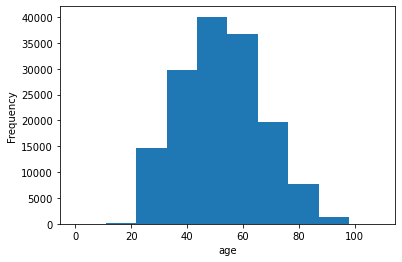

In [28]:
x = df['age'].values
plt.hist(x, bins=10)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.show()

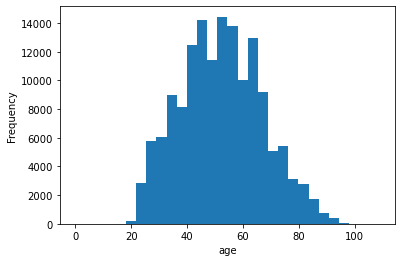

In [29]:
plt.hist(x, bins=30)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.show()

Теперь построим гистограмму распределения возраста.

In [30]:
import seaborn as sns

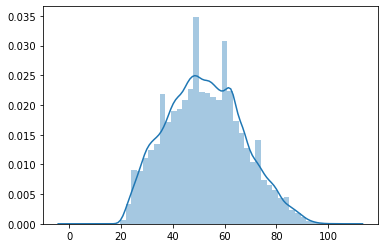

In [31]:
sns.distplot(x)
plt.show()

Построим гистограмму распределения возраста только у заемщиков, которые не вернули кредит.

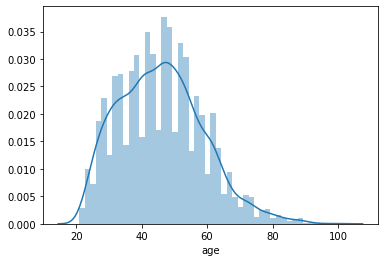

In [32]:
x = df[(df['defaulted'] == 1)]['age'].values
plot = sns.distplot(x)
plot.set(xlabel = 'age')
plt.show()

Построим гистограмму распределения признака ```NumberOfDependents``` для заемщиков, которые успешно вернули кредит.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


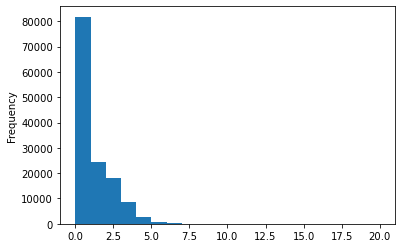

In [33]:
x = df[(df['defaulted'] == 0)]['NumberOfDependents'].values
plt.hist(x, bins=20)
plt.ylabel('Frequency')
plt.show()

Вычислим среднее значение признака ```NumberOfDependents``` для каждого возраста и построим гистограмму распределения полученных значений.

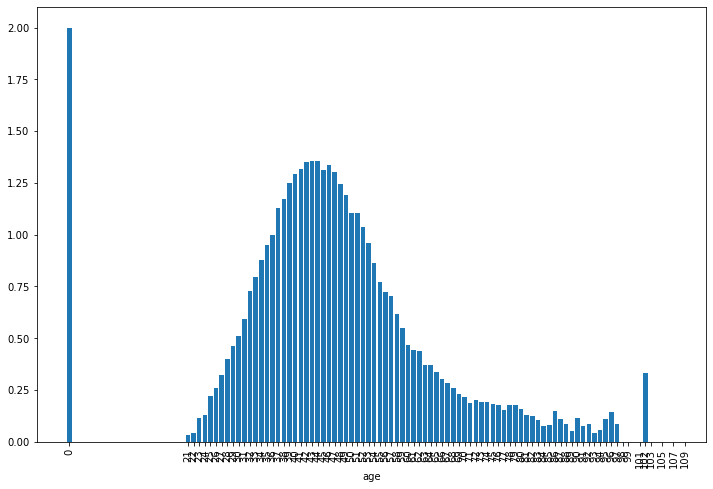

In [34]:
df2 = df.groupby('age')['NumberOfDependents'].mean()
plt.figure(figsize=(12,8))
plt.bar(df2.index, df2.values)
plt.xlabel('age')
plt.xticks(df2.index, rotation=90)
plt.show()

## Обнаружение аномалий в данных

Очистим данные от аномалий.

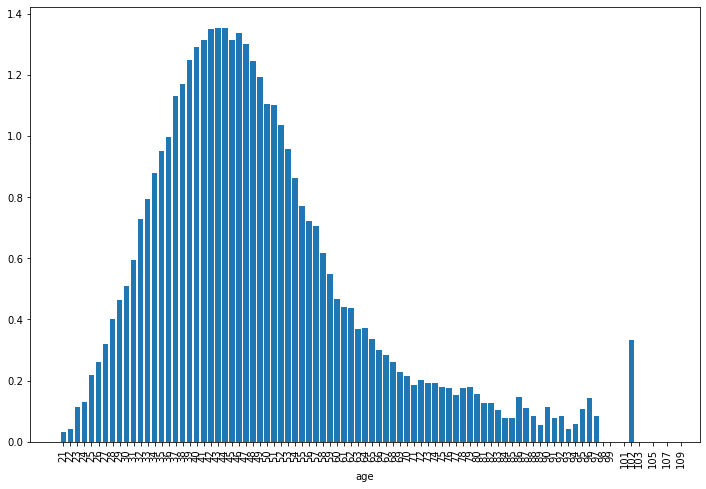

In [35]:
df = df.drop(df[(df['age'] == 0)].index)
df2 = df.groupby('age')['NumberOfDependents'].mean()
plt.figure(figsize=(12,8))
plt.bar(df2.index, df2.values)
plt.xlabel('age')
plt.xticks(df2.index, rotation=90)
plt.show()